Comparing Phoenix models with G430L

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting
from scipy.optimize import leastsq

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [4]:
path = '/media/david/5tb_storage1/muscles/stis_x1ds/'
allspecs = np.hstack((glob.glob(path+'*x1d.fits'), glob.glob(path+'*sx1.fits')))
#allspecs
stars = os.listdir(path)
stars


['2MASS-J23062928-0502285',
 'GJ1132',
 'GJ15A',
 'GJ163',
 'GJ649',
 'GJ674',
 'GJ676A',
 'GJ699',
 'GJ729',
 'GJ849',
 'L-980-5',
 'LHS-2686']

In [5]:
from astropy.convolution import convolve_fft
from astropy.convolution import Gaussian1DKernel

def smear(w,f, R, w_sample=1):
    '''
    Smears a model spectrum with a gaussian kernel to the given resolution, R.
    Adapeted from https://github.com/spacetelescope/pysynphot/issues/78

    Parameters
    -----------

    w,f:  spectrum to smear

    R: int
        The resolution (dL/L) to smear to

    w_sample: int
        Oversampling factor for smoothing

    Returns
    -----------

    sp: PySynphot Source Spectrum
        The smeared spectrum
    '''

    # Save original wavelength grid and units
    w_grid = w
    

    # Generate logarithmic wavelength grid for smoothing
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    n_w = np.size(w_grid)*w_sample
    w_log = np.logspace(w_logmin, w_logmax, num=n_w)

    # Find stddev of Gaussian kernel for smoothing
    R_grid = (w_log[1:-1]+w_log[0:-2])/(w_log[1:-1]-w_log[0:-2])/2
    sigma = np.median(R_grid)/R
    if sigma < 1:
        sigma = 1

    # Interpolate on logarithmic grid
    f_log = np.interp(w_log, w_grid, f)

    # Smooth convolving with Gaussian kernel
    gauss = Gaussian1DKernel(stddev=sigma)
    f_conv = convolve_fft(f_log, gauss)

    # Interpolate back on original wavelength grid
    f_sm = np.interp(w_grid, w_log, f_conv)

    # Write smoothed spectrum back into Spectrum object
    return w_grid, f_sm

GJ1132
../common/stis_test_output/GJ1132/hlsp_muscles_hst_stis_gj1132_g430l_v1_component-spec.ecsv


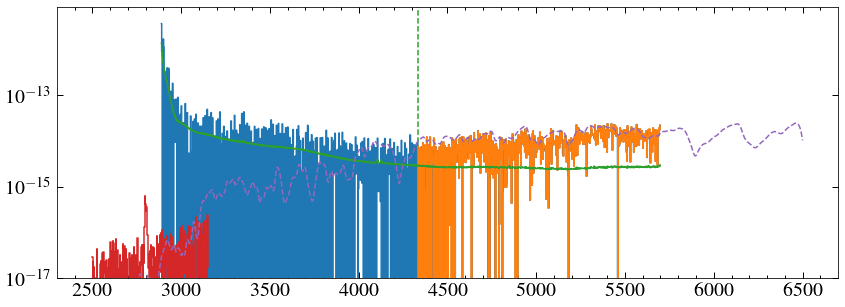

GJ15A
../common/stis_test_output/GJ15A/hlsp_muscles_hst_stis_gj15a_g430l_v1_component-spec.ecsv


/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


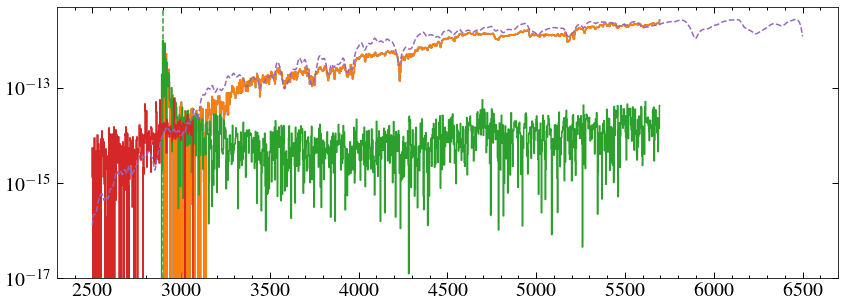

GJ163
../common/stis_test_output/GJ163/hlsp_muscles_hst_stis_gj163_g430l_v1_component-spec.ecsv


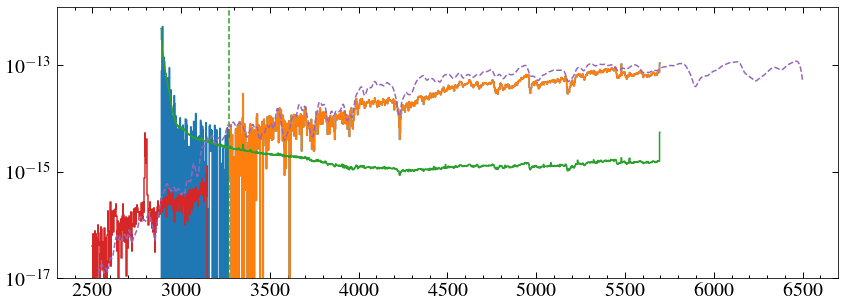

GJ649
../common/stis_test_output/GJ649/hlsp_muscles_hst_stis_gj649_g430l_v1_component-spec.ecsv


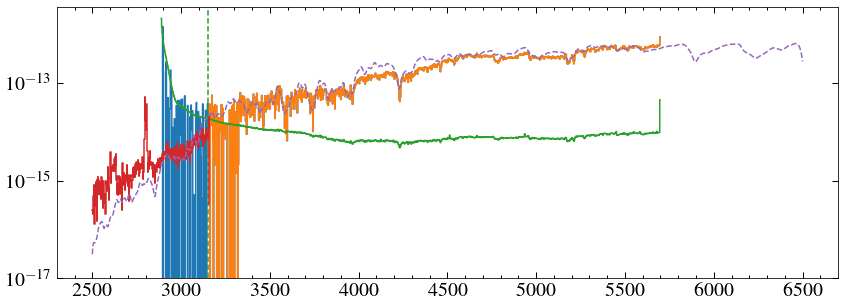

GJ674
../common/stis_test_output/GJ674/hlsp_muscles_hst_stis_gj674_g430l_v1_component-spec.ecsv


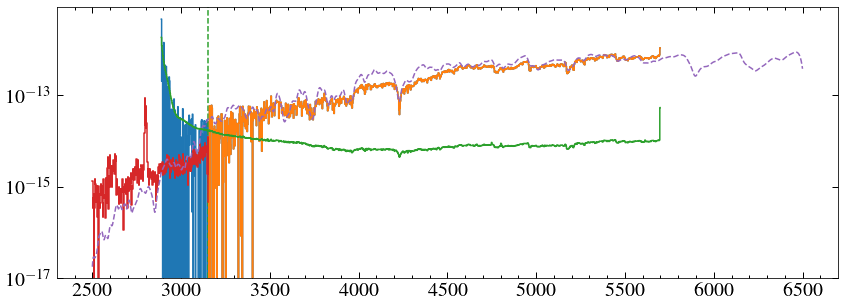

GJ676A
../common/stis_test_output/GJ676A/hlsp_muscles_hst_stis_gj676a_g430l_v1_component-spec.ecsv


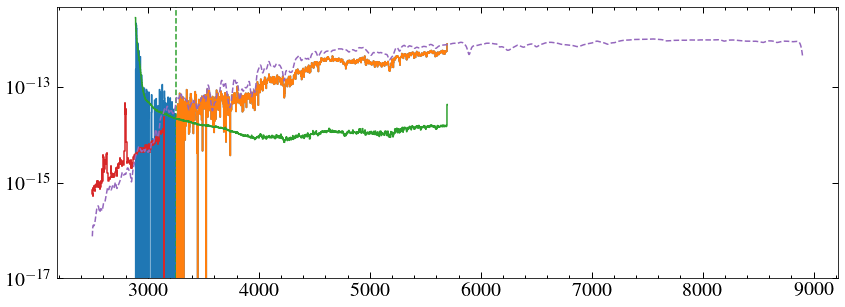

GJ699
../common/stis_test_output/GJ699/hlsp_muscles_hst_stis_gj699_g430l_v1_component-spec.ecsv


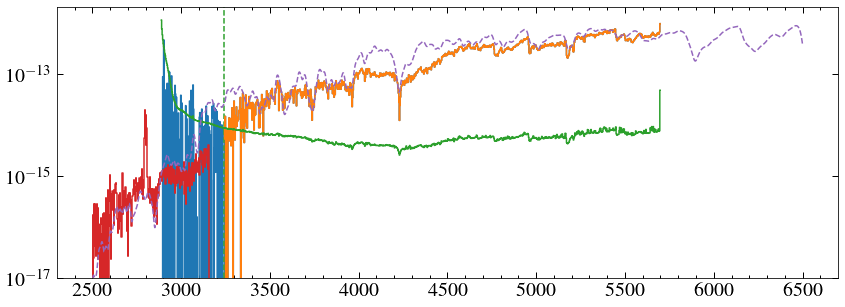

GJ729
../common/stis_test_output/GJ729/hlsp_muscles_hst_stis_gj729_g430l_v1_component-spec.ecsv


/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


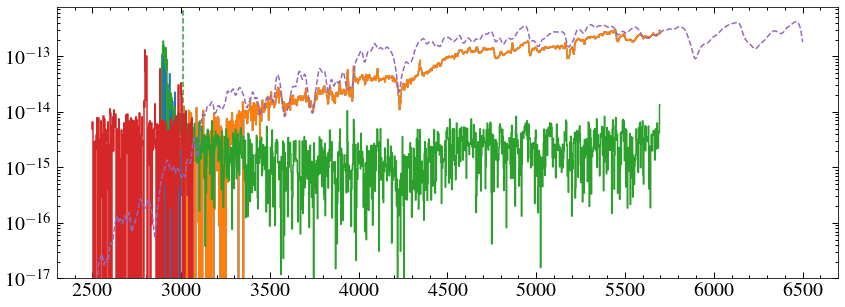

GJ849
../common/stis_test_output/GJ849/hlsp_muscles_hst_stis_gj849_g430l_v1_component-spec.ecsv


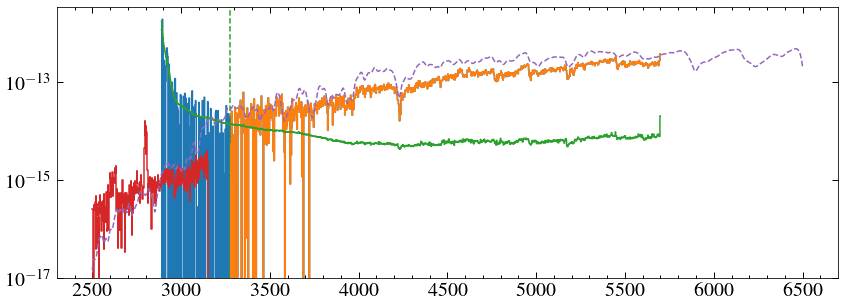

L-980-5
../common/stis_test_output/L-980-5/hlsp_muscles_hst_stis_l-980-5_g430l_v1_component-spec.ecsv


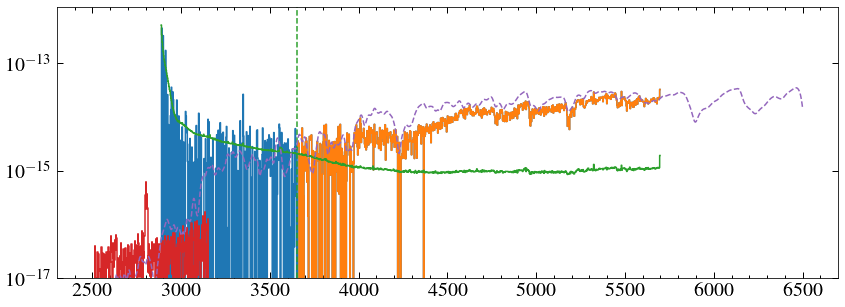

LHS-2686
../common/stis_test_output/LHS-2686/hlsp_muscles_hst_stis_lhs-2686_g430l_v1_component-spec.ecsv


/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


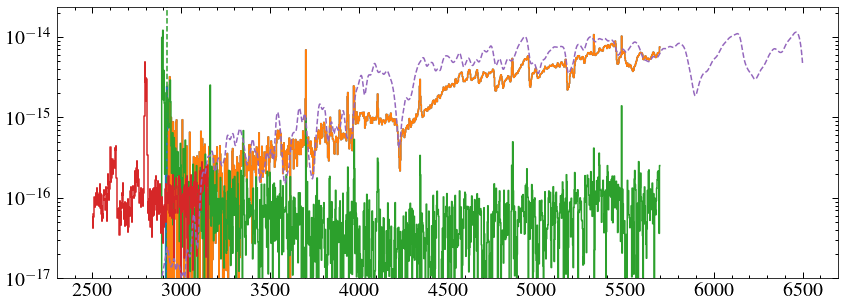

In [6]:
phoenix_path = '/media/david/5tb_storage1/muscles/phoenix_models/'
g430ls = []
grating_order = ['G430L','G230L', 'G230LB']
for star in stars[1:]:
    print(star)
    specs = glob.glob('../common/stis_test_output/{}/*ecsv'.format(star))
    w1 = 2500
    for grating in grating_order:
        for spec in specs:
            data= Table.read(spec)
            if data.meta['GRATING'] == grating:
                w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
                mask = (w > w1)
                w, f, e = w[mask], f[mask], e[mask]
                plt.step(w, f, where='mid')
                if grating == 'G430L':
                    g430ls.append(spec)
                    print(spec)
                    bin_width = 30
                    sn = np.array([np.mean(f[i:i+bin_width]/e[i:i+bin_width]) for i in range(len(w[:-bin_width]))])
                    start = w[:-bin_width][np.where(sn > 1)[0][0]]
                    plt.axvline(start, ls='--', c='C2')
                    plt.step(w[w >start], f[w > start], where='mid')

                    
                    plt.step(w, e, where='mid')
                    #emask = (f/e >1)
                    #plt.step(w[emask], f[emask], where='mid')
                #w1 = w[-1]
            
    opath = glob.glob(phoenix_path+star+'*')
   # print(opath)
    pdata = Table.read(opath[0], data_end= 200000)
    w, f, e  = pdata['WAVELENGTH'], pdata['FLUX']*pdata.meta['NORMFAC'], np.zeros(len(pdata['WAVELENGTH']))
    mask = w > 2500
    w, f, e = w[mask], f[mask], e[mask]
    w, f = smear(w, f, 500)
    plt.plot(w, f, ls='--')
    #plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1e-17)
    plt.show()
        

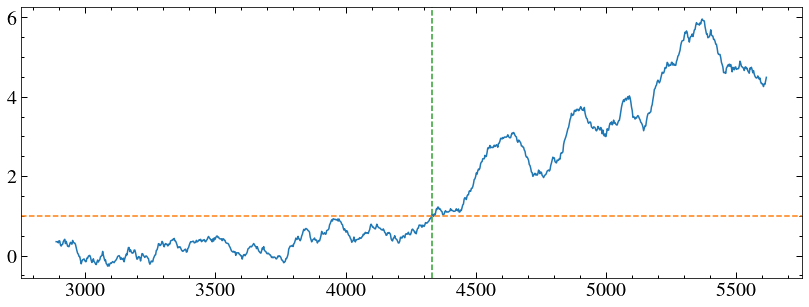

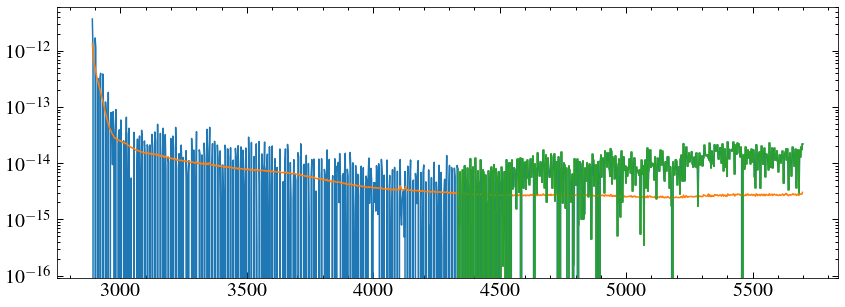

In [7]:

#Table.read.help('ascii.ecsv')
testspec = '../common/stis_test_output/GJ1132/hlsp_muscles_hst_stis_gj1132_g430l_v1_component-spec.ecsv'
data = Table.read(testspec)
w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
bin_width = 30
sn = np.array([np.mean(f[i:i+bin_width]/e[i:i+bin_width]) for i in range(len(w[:-bin_width]))])
plt.plot(w[:-bin_width], sn)
plt.axhline(1, ls='--', c='C1')
start = w[:-50][np.where(sn > 1)[0][0]]
plt.axvline(start, ls='--', c='C2')
plt.show()

plt.plot(w,f)
plt.plot(w,e)
plt.yscale('log')

plt.step(w[w >start], f[w > start], where='mid')


/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


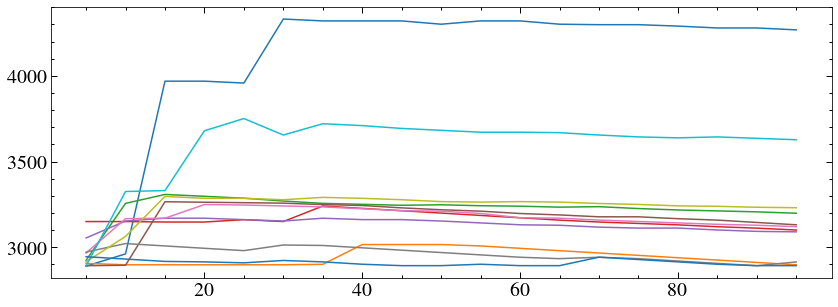

In [8]:
for spec in g430ls:
    data = Table.read(spec)
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    widths = np.arange(5, 100, 5)
    cut_starts = []
    for bin_width in widths:
        sn = np.array([np.mean(f[i:i+bin_width]/e[i:i+bin_width]) for i in range(len(w[:-bin_width]))])
        start = w[:-bin_width][np.where(sn > 1)[0][0]]
        cut_starts.append(start)
    plt.plot(widths, cut_starts)

GJ1132
[1.43526562]


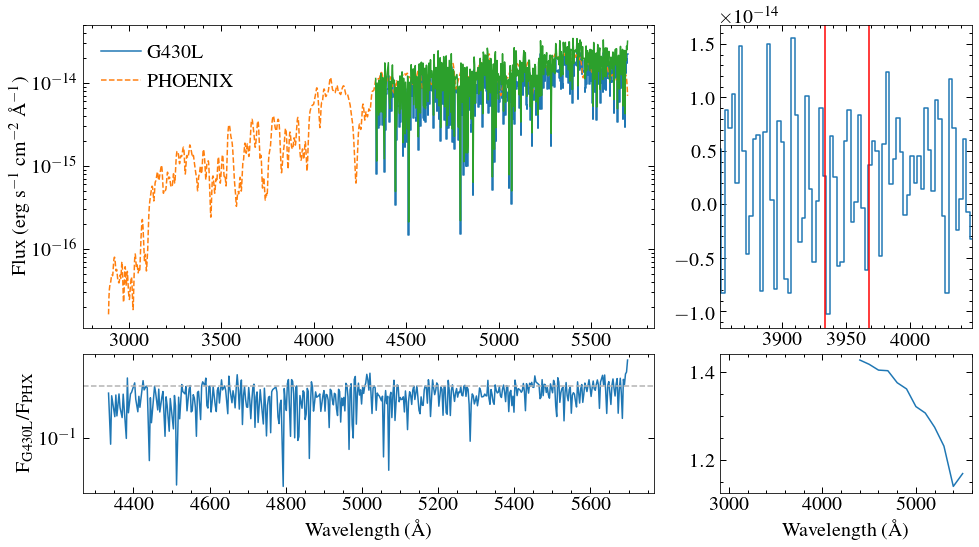

GJ15A


/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


[1.21923175]


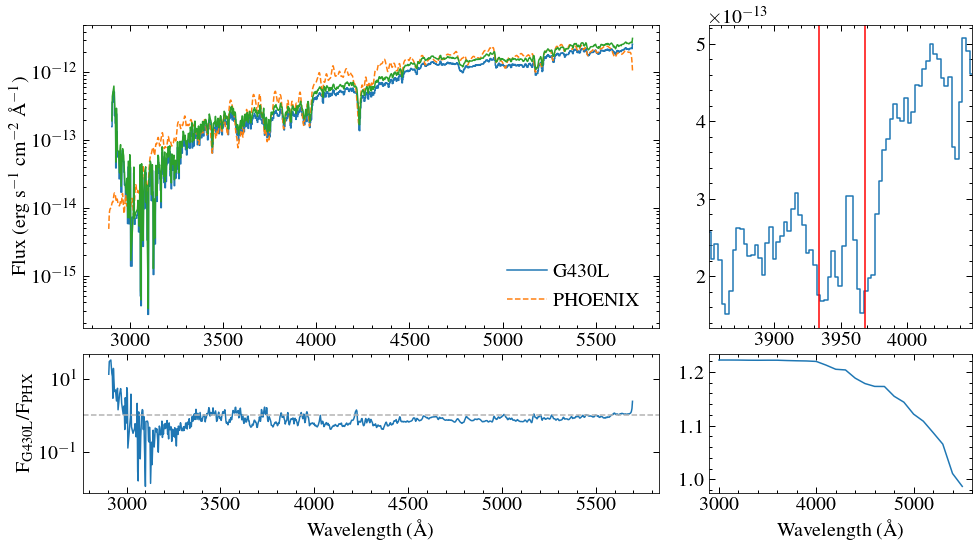

GJ163
[1.45614052]


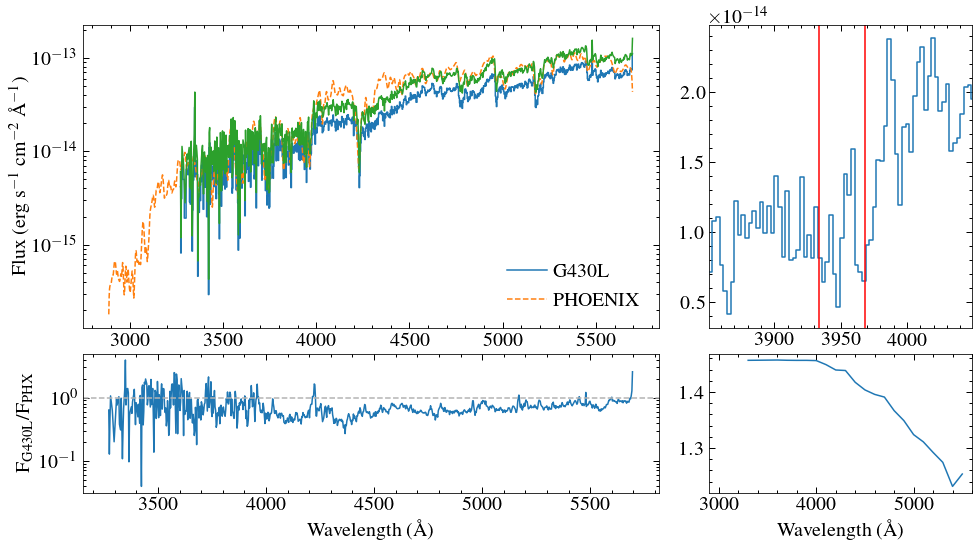

GJ649
[1.11365736]


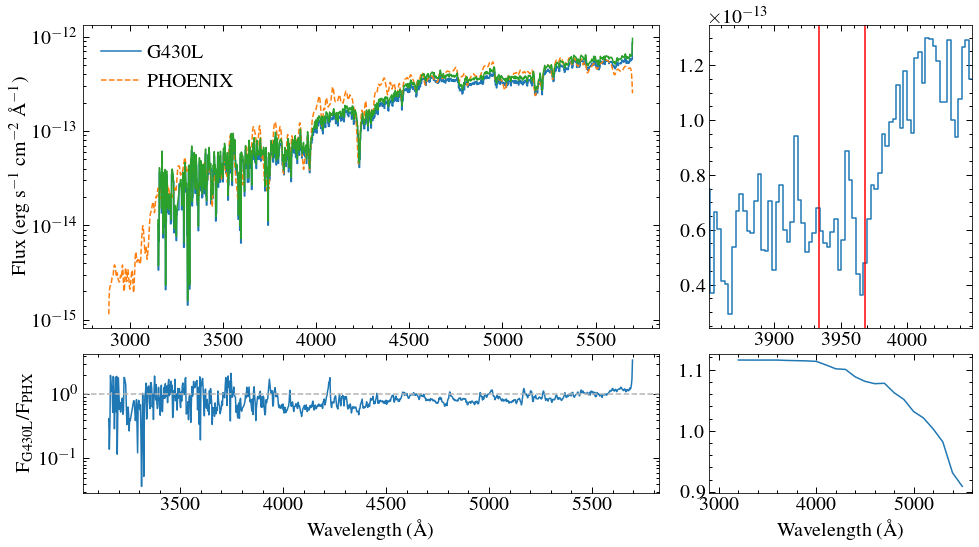

GJ674
[1.14283033]


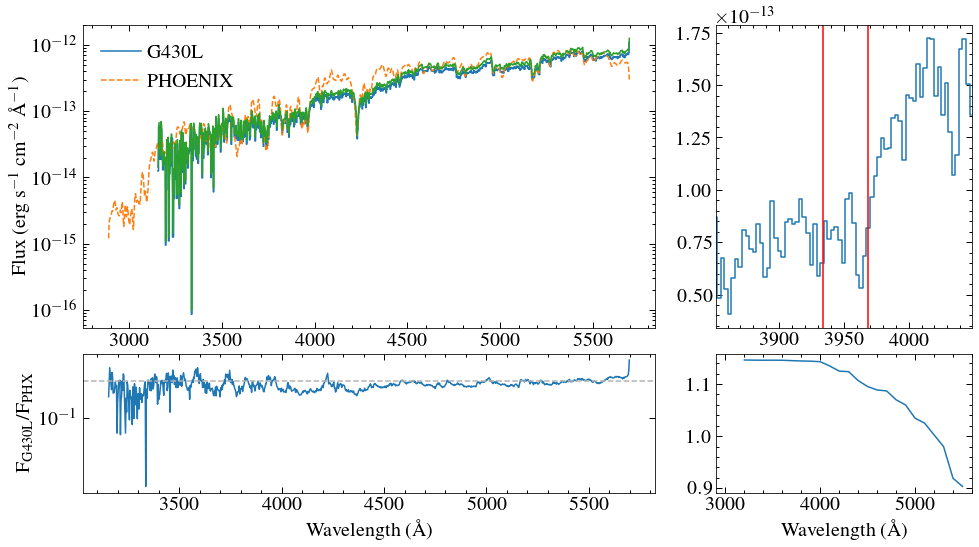

GJ676A
[1.55590579]


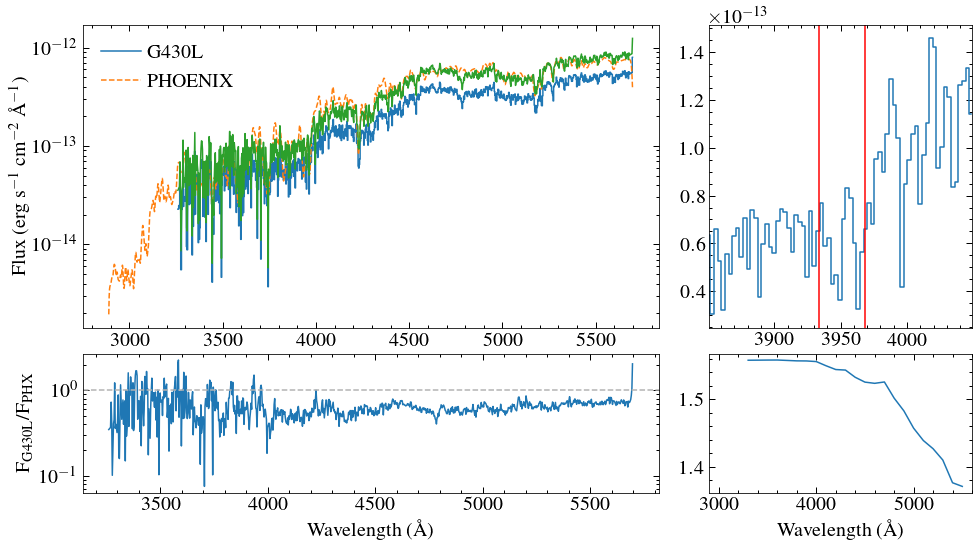

GJ699
[1.30074646]


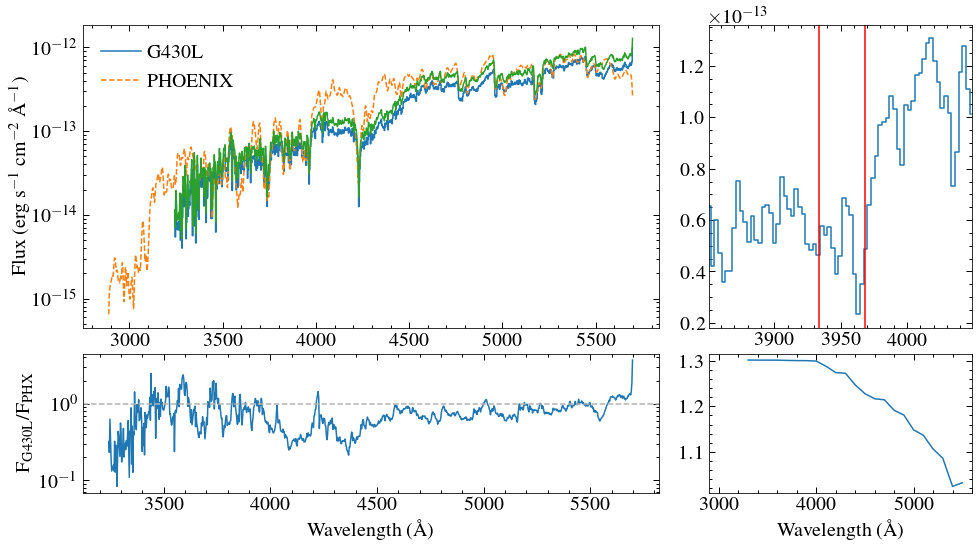

GJ729


/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


[1.58961028]


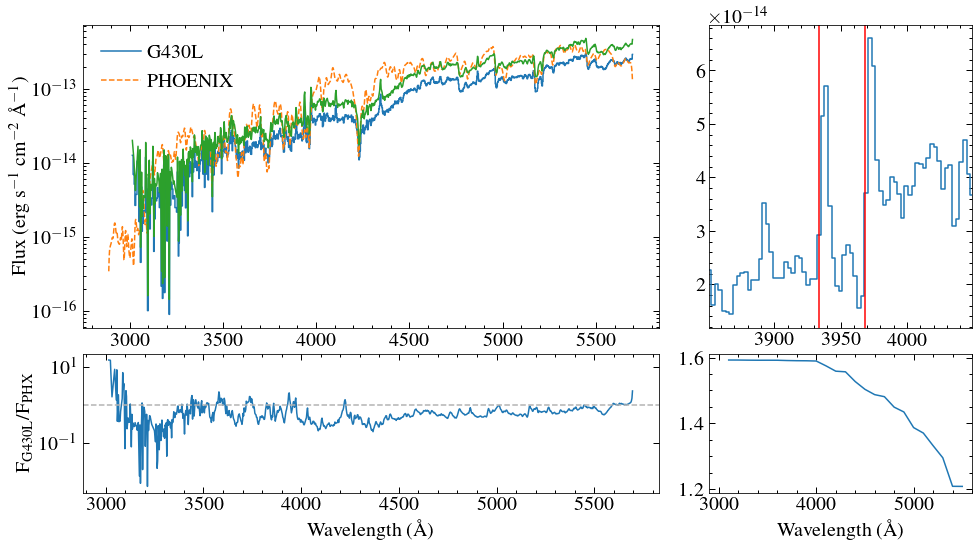

GJ849
[1.68197123]


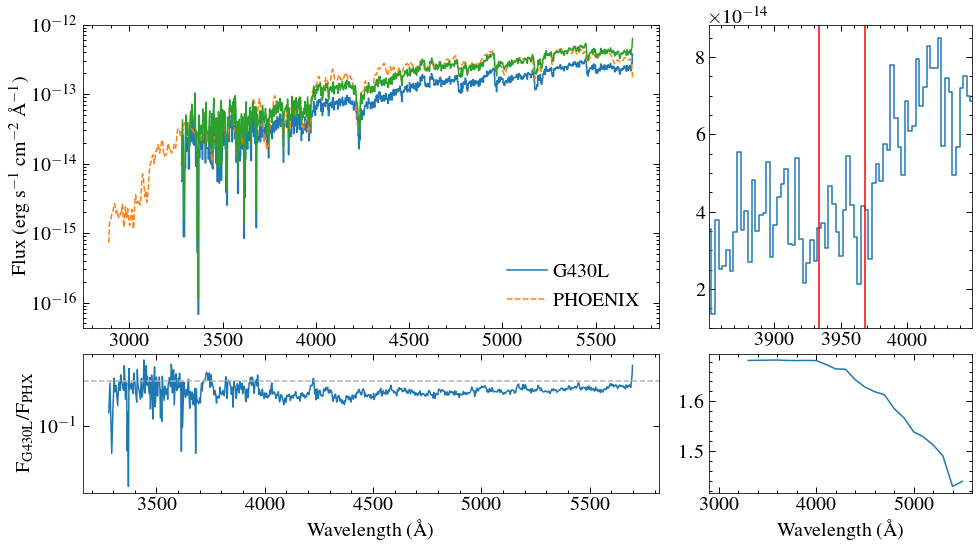

L-980-5
[1.44194407]


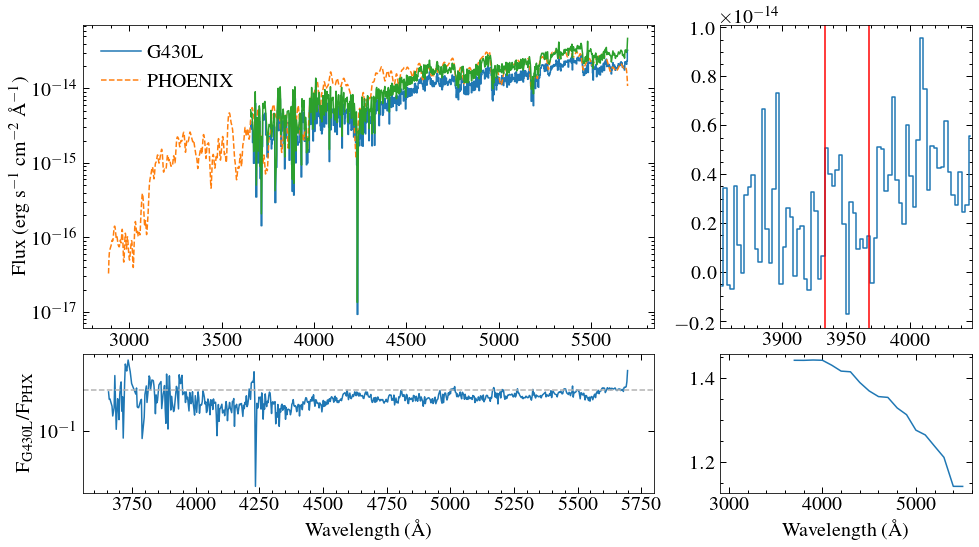

LHS-2686


/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


[1.55058774]


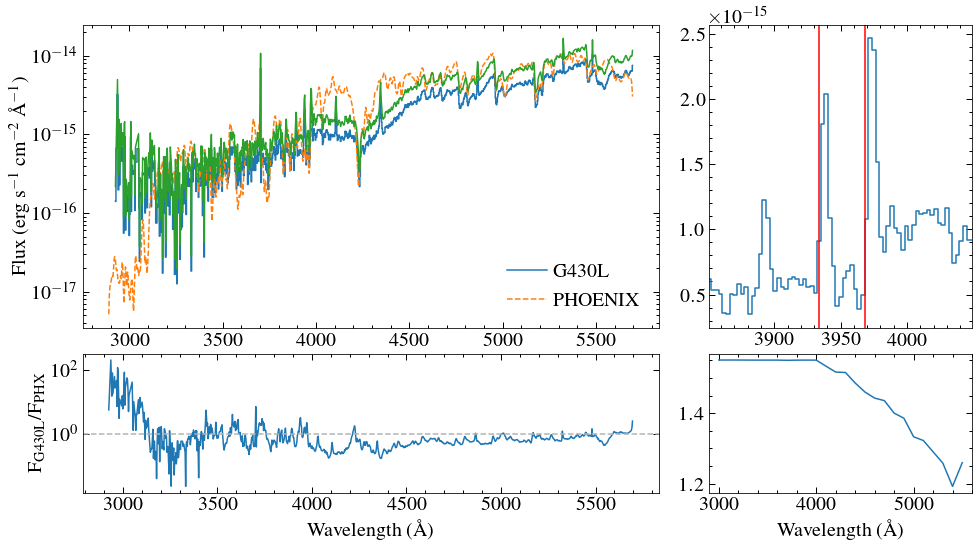

In [24]:
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
ca =[ 3933.6614, 3968.4673]

def residuals(scale, f, mf):
    return f - mf/scale

grating_order = ['G430L']
for star in stars[1:]:
    fig = plt.figure(figsize=(14, 8))
    gs = GridSpec(6, 6, figure=fig)
    ax = plt.subplot(gs[:4, :-2])
    print(star)
    specs = glob.glob('../common/stis_test_output/{}/*ecsv'.format(star))
    for grating in grating_order:
        for spec in specs:
            data= Table.read(spec)
            if data.meta['GRATING'] == grating:
                w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
                bin_width = 30
                sn = np.array([np.mean(f[i:i+bin_width]/e[i:i+bin_width]) for i in range(len(w[:-bin_width]))])
                start = w[:-bin_width][np.where(sn > 1)[0][0]]
                mask = (w > start) & (f > 0)
                w1, f1 , e1 = w[mask], f[mask], e[mask]
                plt.step(w1, f1, where='mid', label=grating)
                
               
    opath = glob.glob(phoenix_path+star+'*')
    pdata = Table.read(opath[0], data_end= 200000)
    mw, mf = pdata['WAVELENGTH'], pdata['FLUX']*pdata.meta['NORMFAC']
    mask = (mw >= w[0]) & (mw <=w[-1] ) 
    mw, mf = mw[mask], mf[mask]
    mw, mf = smear(mw, mf, 1000)
    plt.plot(mw, mf, ls='--', label='PHOENIX')
    plt.legend()
    #plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20)

#plt.xlabel('Wavelength (\AA)', size=20)
#plt.xticks(visible=False)
    pfr = interpolate.interp1d(mw, mf, fill_value='extrapolate')(w1)
    scale, flag = leastsq(residuals, 1., args=(f1[w1 > 4000], pfr[w1> 4000]))
    plt.plot(w1, f1*scale)
    print(scale)
    
  
  
    plt.subplot(gs[4:,:-2])
    #pwo, pfr = resample.bintogrid(mw, mf, newx=w)
     #print(len(w), len(pwo), len(pfr))
    plt.plot(w1, f1/pfr)
    
    #print(np.median(f1/pfr))
    plt.xlabel('Wavelength (\AA)', size=20)
    plt.ylabel('F$_{\mathrm{G430L}}$/F$_{\mathrm{PHX}}$')
   # plt.xlim(wo[0]-10, wo[-1]+10)
    plt.axhline(1.0, ls='--', c='0.7')
    plt.yscale('log')

    plt.subplot(gs[:4,-2:])
    mask = (w > 3850) & (w < 4050)
    plt.step(w[mask],  f[mask], where='mid')
    #plt.errorbar(w[::3], f[::3], yerr=e[::3], c='C0', ls='none', capsize=5, label = 'G430L')

    [plt.axvline(line, c='r') for line in ca]
   # [plt.annotate('',(line, 1.23e-16), xytext=(line, 1.33e-16), horizontalalignment='center', arrowprops=dict(arrowstyle='-')) for line in ca]
   # plt.annotate('Ca\,{\sc ii}',(np.mean(ca), 6e-17), xytext=(np.mean(ca), 1.35e-16), horizontalalignment='center')

    plt.xlim(3851,4049)
 #   plt.ylim(0.1e-16, 1.49e-16)
#    plt.plot(wo[mask], gg_fit(wo[mask]), lw=2, label='Model fit')
    #plt.legend()
   # plt.xlabel('Wavelength (\AA)', size=20)
    
    plt.subplot(gs[4:,-2:])
    scales = []
    wcut = []
    for wi in np.arange(3000, 5501, 100):
        if wi > w1[0]:
            mask = (w1 > wi)
            scales.append(leastsq(residuals, 1., args=(f1[mask], pfr[mask]))[0])
            wcut.append(wi)
    plt.plot(wcut, scales)        
    plt.xlim(2900, 5600)
    plt.xlabel('Wavelength (\AA)', size=20)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.45)
    plt.show()


(0, 2e-15)

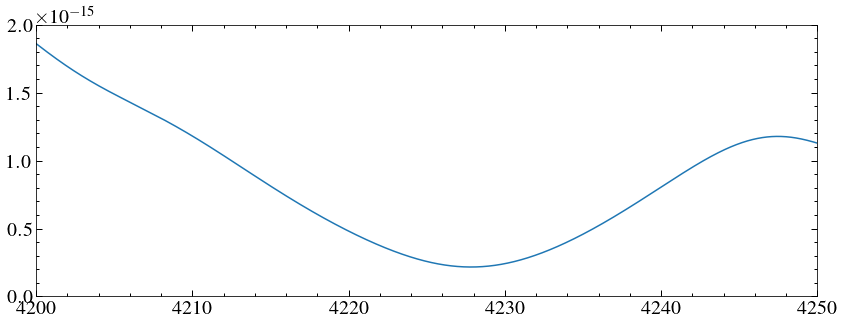

In [10]:
plt.plot(mw, mf)
plt.xlim(4200, 4250)
plt.ylim(0, 2e-15)

Scaling we can come back to. In most cases, the noisy bit of the G430L spectrum is adequately covered by the NUV spectrum. 